### Model Evaluation and Comparative Analysis

##### Importing relevant libraries

In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from surprise import Dataset, Reader, KNNWithMeans, accuracy
from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split as content_train_test_split
from collections import defaultdict

##### Loading Datasets

In [2]:
books_df = pd.read_csv('books_cleaned.csv')
ratings_df = pd.read_csv('ratings_cleaned.csv')

##### Defining Models

In [3]:
  class ContentModel:
    def preprocess_titles(self, df):
        df_titles_1 = df['title'].fillna('').apply(lambda x: re.sub(r'\(.*?\)', '', x).lower().strip())
        return df_titles_1

    def preprocess_authors(self, df):
        df_authors = df['authors'].fillna('').apply(lambda text: re.sub(r'\s+', ' ', re.sub(r'\.', '', str(text).lower().strip())))
        return df_authors

    def remove_stopwords(self, text_series):
        try:
            stop_words = set(stopwords.words('english'))
        except LookupError:
            nltk.download('stopwords')
            stop_words = set(stopwords.words('english'))

        cleaned_text = text_series.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
        return cleaned_text

    def combine_columns(self, df, titles, authors):
        df['combined'] = titles + ' ' + authors
        return df

    def compute_tfidf_matrix(self, df):
        tfidf = TfidfVectorizer()
        tfidf_matrix = tfidf.fit_transform(df['combined'])
        return tfidf_matrix

    def compute_cosine_similarity(self, tfidf_matrix):
        return cosine_similarity(tfidf_matrix)

    def find_book_index(self, df, titles, search_title):
        clean_title = lambda x: re.sub(r'\(.*?\)', '', str(x)).lower().strip()
        search_title = clean_title(search_title)
        filtered_df = df[titles == search_title]
        if not filtered_df.empty:
            return filtered_df.index[0]
        else:
            print(f"'{search_title}' not found in the dataframe.")
            return None

    def get_similar_books(self, df, cos_sim_matrix, idx, top_n, threshold):
        similarity_scores = list(enumerate(cos_sim_matrix[idx]))
        sorted_similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
        book_indices = [i[0] for i in sorted_similarity_scores[1:] if i[1] > threshold][:top_n]
        return df.iloc[book_indices]['book_id'].values

class ContentUserModel:
    def __init__(self, content_model):
        self.content_model = content_model

    def get_highly_rated_titles(self, books_df, ratings_df, user_id, rating_threshold):
        user_ratings = ratings_df[ratings_df['user_id'] == user_id]
        high_rated_books = user_ratings[user_ratings['rating'] >= rating_threshold]
        high_rated_book_ids = high_rated_books['book_id'].tolist()

        high_rated_titles = books_df[books_df['book_id'].isin(high_rated_book_ids)]['title'].tolist()
        return high_rated_titles

    def build_user_profile(self, tfidf_matrix, books_df, high_rated_titles):
        # Get the indices of high rated titles
        relevant_indices = books_df[books_df['title'].isin(high_rated_titles)].index
        # Select only the rows corresponding to these indices in the tfidf_matrix
        user_profile = tfidf_matrix[relevant_indices].mean(axis=0)
        user_profile = np.asarray(user_profile).reshape(1, -1)  # Convert to numpy array and reshape
        return user_profile

    def get_similar_books_user_profile(self, tfidf_matrix, books_df, ratings_df, high_rated_titles, title, top_n):
        user_profile = self.build_user_profile(tfidf_matrix, books_df, high_rated_titles)
        similarity_scores = cosine_similarity(tfidf_matrix, user_profile).flatten()
        similar_indices = similarity_scores.argsort()[::-1]

        similar_titles = books_df.iloc[similar_indices]['title'].tolist()
        similar_titles = [t for t in similar_titles if t != title][:top_n]
        return similar_titles

    def recommend_books_for_user(self, books_df, ratings_df, user_id, title, n, rating_threshold=4):
        # Preprocess and combine columns using ContentModel
        books_df_titles = books_df['title']
        books_df_titles_1 = self.content_model.remove_stopwords(books_df_titles)
        books_df_authors = books_df['authors']
        content_books_df = self.content_model.combine_columns(books_df, books_df_titles_1, books_df_authors)

        # Compute the TF-IDF matrix
        tfidf_matrix = self.content_model.compute_tfidf_matrix(content_books_df)

        # Get high rated titles for the user
        high_rated_titles = self.get_highly_rated_titles(books_df, ratings_df, user_id, rating_threshold)

        # Get similar books based on the user's profile
        similar_books = self.get_similar_books_user_profile(tfidf_matrix, content_books_df, ratings_df, high_rated_titles, title, n)
        
        return similar_books

class CollaborativeModel:
    
    def create_surprise_data(self, ratings_df):
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(ratings_df[["user_id", "book_id", "rating"]], reader)
        return data

    def build_and_train_model(self, trainset, k):
        sim_options = {
            "name": "cosine",
            "user_based": False,  # Compute similarities between items
        }
        algo = KNNWithMeans(k=k, min_k=1, sim_options=sim_options)
        algo.fit(trainset)
        return algo

    def get_collaborative_recommendations(self, title, n, ratings_df, books_df, k):
        # Create Surprise data
        data = self.create_surprise_data(ratings_df)

        # Build and train the model
        trainset = data.build_full_trainset()
        algo = self.build_and_train_model(trainset, k)

        # Find the book_id for the given title
        book_id = books_df[books_df['title'].str.lower() == title.lower()]['book_id'].values[0]

        # Get the inner id corresponding to the book_id
        inner_id = algo.trainset.to_inner_iid(book_id)

        # Get the neighbors of the book (n similar books)
        neighbors = algo.get_neighbors(inner_id, k=n)

        # Convert inner ids of neighbors to book_ids
        neighbor_book_ids = [algo.trainset.to_raw_iid(inner_id) for inner_id in neighbors]

        # Map book_ids back to titles
        recommendations = books_df[books_df['book_id'].isin(neighbor_book_ids)]['title'].values

        return recommendations

class HybridModel:
    def __init__(self, content_user_model, collaborative_model):
        self.content_user_model = content_user_model
        self.collaborative_model = collaborative_model

    def recommend_books(self, books_df, ratings_df, user_id, title, n, rating_threshold=4, k=30):
        # Content-Based Recommendations
        books_df_titles = books_df['title']
        books_df_titles_1 = self.content_user_model.content_model.remove_stopwords(books_df_titles)
        books_df_authors = books_df['authors']
        content_books_df = self.content_user_model.content_model.combine_columns(books_df, books_df_titles_1, books_df_authors)

        tfidf_matrix = self.content_user_model.content_model.compute_tfidf_matrix(content_books_df)

        high_rated_titles = self.content_user_model.get_highly_rated_titles(books_df, ratings_df, user_id, rating_threshold)
        content_recommendations = self.content_user_model.get_similar_books_user_profile(
            tfidf_matrix, content_books_df, ratings_df, high_rated_titles, title, n
        )

        # Collaborative Filtering Recommendations
        collaborative_recommendations = self.collaborative_model.get_collaborative_recommendations(title, n, ratings_df, books_df, k)

        # Hybrid approach: Combine the scores from both collaborative and content-based recommendations
        hybrid_recommendations = list(set(content_recommendations) | set(collaborative_recommendations))

        # Limit to top-N hybrid recommendations
        hybrid_recommendations = hybrid_recommendations[:n]

        return hybrid_recommendations, high_rated_titles


##### Defining Evaluator class

In [4]:
class Evaluator:

    # Precision, Recall, MRR, and NDCG functions
    def precision_at_n(self, relevant_items, recommended_items, n):
        recommended_at_n = recommended_items[:n]
        relevant_set = set(relevant_items)
        recommended_set = set(recommended_at_n)
        if not recommended_set:
            return 0.0
        precision = len(relevant_set & recommended_set) / len(recommended_set)
        return precision

    def recall_at_n(self, relevant_items, recommended_items, n):
        recommended_at_n = recommended_items[:n]
        relevant_set = set(relevant_items)
        recommended_set = set(recommended_at_n)
        if not relevant_set:
            return 0.0
        recall = len(relevant_set & recommended_set) / len(relevant_set)
        return recall

    def mean_reciprocal_rank(self, relevant_items, recommended_items):
        for i, item in enumerate(recommended_items):
            if item in relevant_items:
                return 1 / (i + 1)
        return 0

    def ndcg_at_n(self, relevant_items, recommended_items, n):
        dcg = 0.0
        for i, item in enumerate(recommended_items[:n]):
            if item in relevant_items:
                dcg += 1 / np.log2(i + 2)
        idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant_items), n)))
        ndcg = dcg / idcg if idcg > 0 else 0
        return ndcg
        
    def precision_recall_at_k(self, predictions, k=10, threshold=3.5):
        user_est_true = defaultdict(list)
        y_true = []
        y_pred = []
    
        for uid, iid, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))
            y_true.append(1 if true_r >= threshold else 0)
            y_pred.append(1 if est >= threshold else 0)
    
        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    
        return precisions, recalls, y_true, y_pred
    
    def ndcg_at_k(self, predictions, k=10, threshold=3.5):
        def dcg(scores):
            return np.sum([(2**score - 1) / np.log2(idx + 2) for idx, score in enumerate(scores)])

        user_est_true = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        ndcgs = dict()
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            dcg_k = dcg([true_r for _, true_r in user_ratings[:k]])
            idcg_k = dcg(sorted([true_r for _, true_r in user_ratings], reverse=True)[:k])
            ndcgs[uid] = dcg_k / idcg_k if idcg_k != 0 else 0

        return ndcgs

    def mrr_at_k(self, predictions, k=10, threshold=3.5):
        user_est_true = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        mrrs = dict()
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            for rank, (_, true_r) in enumerate(user_ratings[:k], start=1):
                if true_r >= threshold:
                    mrrs[uid] = 1 / rank
                    break
            else:
                mrrs[uid] = 0

        return mrrs
       
    # Evaluation function for ContentModel
    def evaluate_content_model(self, content_model, df, test_sizes, n, threshold):
        results = {}
        
        for test_size in test_sizes:
            train_df, test_df = content_train_test_split(df, test_size=test_size)
            df_titles_1 = content_model.preprocess_titles(df)
            df_authors = content_model.preprocess_authors(df)
            df_titles_2 = content_model.remove_stopwords(df_titles_1)
            df = content_model.combine_columns(df, df_titles_2, df_authors)

            tfidf_matrix = content_model.compute_tfidf_matrix(df)
            cos_sim_matrix = content_model.compute_cosine_similarity(tfidf_matrix)
            
            precisions = []
            recalls = []
            ndcgs = []
            mrrs = []
            y_true = []
            y_pred = []
            
            for idx, row in test_df.iterrows():
                book_idx = content_model.find_book_index(df, df_titles_1, row['title'])
                
                if book_idx is not None:
                    similar_books = content_model.get_similar_books(df, cos_sim_matrix, book_idx, n, threshold)
                    relevant_items = [row['book_id']]
                    
                    # Align lengths of y_true and y_pred
                    y_true.extend([1 if item in relevant_items else 0 for item in similar_books])
                    y_pred.extend([1] * len(similar_books))  # All predicted items are positives
                    
                    precisions.append(self.precision_at_n(relevant_items, similar_books, n))
                    recalls.append(self.recall_at_n(relevant_items, similar_books, n))
                    ndcgs.append(self.ndcg_at_n(relevant_items, similar_books, n))
                    mrrs.append(self.mean_reciprocal_rank(relevant_items, similar_books))
                    
            # Compute confusion matrix, F1 score, and accuracy
            conf_matrix = confusion_matrix(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            accuracy = accuracy_score(y_true, y_pred)
            
            results[test_size] = {
                'Precision@N': np.mean(precisions),
                'Recall@N': np.mean(recalls),
                'NDCG@N': np.mean(ndcgs),
                'MRR@N': np.mean(mrrs),
                'Confusion Matrix': conf_matrix,
                'F1 Score': f1,
                'Accuracy': accuracy
            }
        
        return results

    # Evaluation function for ContentUserModel
    def evaluate_content_user_model(self, content_user_model, df, ratings_df, user_id, test_sizes, n, rating_threshold):
        results = {}
        
        for test_size in test_sizes:
            train_df, test_df = content_train_test_split(df, test_size=test_size)
            df_titles_1 = content_user_model.content_model.preprocess_titles(df)
            df_authors = content_user_model.content_model.preprocess_authors(df)
            df_titles_2 = content_user_model.content_model.remove_stopwords(df_titles_1)
            df = content_user_model.content_model.combine_columns(df, df_titles_2, df_authors)

            tfidf_matrix = content_user_model.content_model.compute_tfidf_matrix(df)
            high_rated_titles = content_user_model.get_highly_rated_titles(df, ratings_df, user_id, rating_threshold)
            
            precisions = []
            recalls = []
            ndcgs = []
            mrrs = []
            y_true = []
            y_pred = []
            
            for idx, row in test_df.iterrows():
                similar_books = content_user_model.get_similar_books_user_profile(tfidf_matrix, df, ratings_df, high_rated_titles, row['title'], top_n=n)
                relevant_items = high_rated_titles
                
                # Align lengths of y_true and y_pred
                y_true.extend([1 if item in relevant_items else 0 for item in similar_books])
                y_pred.extend([1] * len(similar_books))  # All predicted items are positives
                
                precisions.append(self.precision_at_n(relevant_items, similar_books, n))
                recalls.append(self.recall_at_n(relevant_items, similar_books, n))
                ndcgs.append(self.ndcg_at_n(relevant_items, similar_books, n))
                mrrs.append(self.mean_reciprocal_rank(relevant_items, similar_books))
                    
            # Compute confusion matrix, F1 score, and accuracy
            conf_matrix = confusion_matrix(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            accuracy = accuracy_score(y_true, y_pred)
            
            results[test_size] = {
                'Precision@N': np.mean(precisions),
                'Recall@N': np.mean(recalls),
                'NDCG@N': np.mean(ndcgs),
                'MRR@N': np.mean(mrrs),
                'Confusion Matrix': conf_matrix,
                'F1 Score': f1,
                'Accuracy': accuracy
            }
        
        return results

    

    # Evaluation function for HybridModel
    def evaluate_hybrid_model(self, hybrid_model, books_df, ratings_df, title, user_id, n, rating_threshold, test_sizes, k):
        results = {}
        
        for test_size in test_sizes:
            train_df, test_df = content_train_test_split(ratings_df, test_size=test_size, random_state=42)
            hybrid_recommendations, relevant_items = hybrid_model.recommend_books(books_df, train_df, user_id, title, n, rating_threshold, k)
            y_true = [1 if item in relevant_items else 0 for item in hybrid_recommendations]
            y_pred = [1] * len(hybrid_recommendations)  # All predicted items are positives
           
            precision = self.precision_at_n(relevant_items, hybrid_recommendations, n)
            recall = self.recall_at_n(relevant_items, hybrid_recommendations, n)
            ndcg = self.ndcg_at_n(relevant_items, hybrid_recommendations, n)
            mrr = self.mean_reciprocal_rank(relevant_items, hybrid_recommendations)
               
            conf_matrix = confusion_matrix(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            accuracy = accuracy_score(y_true, y_pred)
       
            results[test_size] = {
            'Precision@N': np.mean(precision),
            'Recall@N': np.mean(recall),
            'NDCG@N': np.mean(ndcg),
            'MRR@N': np.mean(mrr),
            'Confusion Matrix': conf_matrix,
            'F1 Score': f1,
            'Accuracy': accuracy
        }
   
        return results
    # Evaluation functions for collaborative model
    def evaluate_collaborative_model_constant_test_size(self, collaborative_model, ratings_df, test_size, ks, n=10):
        data = collaborative_model.create_surprise_data(ratings_df)
        trainset, testset = train_test_split(data, test_size=test_size)
        results = {}
        y_test_all = []
        y_pred_all = []
        for k in ks:
            algo = collaborative_model.build_and_train_model(trainset, k)
            predictions = algo.test(testset)
            rmse = accuracy.rmse(predictions, verbose=False)
            mae = accuracy.mae(predictions, verbose=False)
            precisions, recalls, y_true, y_pred = self.precision_recall_at_k(predictions, k=n)
            ndcgs = self.ndcg_at_k(predictions, k=n)
            mrrs = self.mrr_at_k(predictions, k=n)
            precision_n = sum(prec for prec in precisions.values()) / len(precisions)
            recall_n = sum(rec for rec in recalls.values()) / len(recalls)
            ndcg_n = sum(ndcg for ndcg in ndcgs.values()) / len(ndcgs)
            mrr_n = sum(mrr for mrr in mrrs.values()) / len(mrrs)
        
            # Compute confusion matrix, F1 score, and accuracy
            conf_matrix = confusion_matrix(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            acc = accuracy_score(y_true, y_pred)
        
            results[k] = {
            'RMSE': rmse,
            'MAE': mae,
            'Precision@N': precision_n,
            'Recall@N': recall_n,
            'NDCG@N': ndcg_n,
            'MRR@N': mrr_n,
            'Confusion Matrix': conf_matrix,
            'F1 Score': f1,
            'Accuracy': acc
        }

       
        return results

    # Constant Nearest Neighbour
    def evaluate_collaborative_model_constant_nearest_neighbour(self, collaborative_model, ratings_df, test_sizes, k=30, n=10):
        data = collaborative_model.create_surprise_data(ratings_df)
        results = {}
        y_test_all = []
        y_pred_all = []
        for test_size in test_sizes:
            trainset, testset = train_test_split(data, test_size=test_size)
            algo = collaborative_model.build_and_train_model(trainset, k)
            predictions = algo.test(testset)
            rmse = accuracy.rmse(predictions, verbose=False)
            mae = accuracy.mae(predictions, verbose=False)
            precisions, recalls, y_true, y_pred = self.precision_recall_at_k(predictions, k=n)
            ndcgs = self.ndcg_at_k(predictions, k=n)
            mrrs = self.mrr_at_k(predictions, k=n)
            precision_n = sum(prec for prec in precisions.values()) / len(precisions)
            recall_n = sum(rec for rec in recalls.values()) / len(recalls)
            ndcg_n = sum(ndcg for ndcg in ndcgs.values()) / len(ndcgs)
            mrr_n = sum(mrr for mrr in mrrs.values()) / len(mrrs)
        
            # Compute confusion matrix, F1 score, and accuracy
            conf_matrix = confusion_matrix(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            acc = accuracy_score(y_true, y_pred)
        
            results[test_size] = {
            'RMSE': rmse,
            'MAE': mae,
            'Precision@N': precision_n,
            'Recall@N': recall_n,
            'NDCG@N': ndcg_n,
            'MRR@N': mrr_n,
            'Confusion Matrix': conf_matrix,
            'F1 Score': f1,
            'Accuracy': acc
        }

        
        return results

##### Evaluating Models

In [5]:
# Create model instances
content_model = ContentModel()
content_user_model = ContentUserModel(content_model)
collaborative_model = CollaborativeModel()
hybrid_model = HybridModel(content_user_model, collaborative_model)

# Create an Evaluator instance
evaluator = Evaluator()

# Evaluate the content model
print('Evaluating content model')
test_sizes=[0.2, 0.3, 0.4, 0.5]
n=10
threshold=0.1
content_results = evaluator.evaluate_content_model(content_model, books_df, test_sizes, n, threshold)
print(content_results)

# Evaluate the content-user model
print('Evaluating content user model')
user_id=1
test_sizes=[0.2, 0.3, 0.4, 0.5]
n=10
rating_threshold=4
content_user_results = evaluator.evaluate_content_user_model(content_user_model, books_df, ratings_df, user_id, test_sizes, n, rating_threshold)
print(content_user_results)  

# Evaluate Collaborative model constant test size
print('Evaluating collaborative model')
test_size=0.2
ks=[10, 20, 30, 40, 50]
n=10
collaborative_results1 = evaluator.evaluate_collaborative_model_constant_test_size(collaborative_model, ratings_df, test_size, ks, n)
print(collaborative_results1)

# Evaluate collaborative model constant nearest neighbour
test_sizes=[0.2, 0.3, 0.4, 0.5]
k=30
n=10
collaborative_results2 = evaluator.evaluate_collaborative_model_constant_nearest_neighbour(collaborative_model, ratings_df, test_sizes, k, n)
print(collaborative_results2)

# Evaluate Hybrid model
print('Evaluating hybrid model')
title='The Great Gatsby'
user_id=1
test_sizes=[0.2, 0.3, 0.4, 0.5]
n=10
rating_threshold=4
k=30
hybrid_results = evaluator.evaluate_hybrid_model(hybrid_model, books_df, ratings_df, title, user_id, n, rating_threshold, test_sizes, k)
print(hybrid_results)


Evaluating content model


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\796656\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


{0.2: {'Precision@N': 0.002082635399218314, 'Recall@N': 0.018090452261306532, 'NDCG@N': 0.012258950341134299, 'MRR@N': 0.01049872377761825, 'Confusion Matrix': array([[    0, 19305],
       [    0,    36]], dtype=int64), 'F1 Score': 0.0037157454714352067, 'Accuracy': 0.0018613308515588647}, 0.3: {'Precision@N': 0.0015950120975246603, 'Recall@N': 0.01574539363484087, 'NDCG@N': 0.009375384536011758, 'MRR@N': 0.007438515327962565, 'Confusion Matrix': array([[    0, 29030],
       [    0,    47]], dtype=int64), 'F1 Score': 0.0032275786293091612, 'Accuracy': 0.001616397840217354}, 0.4: {'Precision@N': 0.0016254885538805137, 'Recall@N': 0.01457286432160804, 'NDCG@N': 0.008585222183699401, 'MRR@N': 0.006751714923825477, 'Confusion Matrix': array([[    0, 38662],
       [    0,    58]], dtype=int64), 'F1 Score': 0.002991386868843159, 'Accuracy': 0.0014979338842975207}, 0.5: {'Precision@N': 0.0013162891480141179, 'Recall@N': 0.013067953357458785, 'NDCG@N': 0.008691372224949681, 'MRR@N': 0.00734

#### Comparative Analysis

In [8]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [9]:
# Display DataFrame as table
def display_data_in_table(df, title):
    display(HTML(f"<h2 style='text-align:center;'>{title}</h2>"))
    display(HTML(df.to_html(index=False)))

def display_data_in_graph(df, title, label):
    # Plotting the data
    plt.figure(figsize=(10, 6))

    # Convert to numpy arrays to avoid indexing issues
    x = df['Specific Weight of Training Set'].values
    content_based = df['Content-Based filtering Algorithm'].values
    content_based_user_profile = df['Content-Based filtering with user profile Algorithm'].values
    collaborative = df['Collaborative filtering Algorithm'].values
    hybrid = df['Hybrid filtering Algorithm'].values

    # Plot Content-Based filtering Algorithm
    plt.plot(x, content_based, marker='o', linestyle='-', color='blue', label='Content-Based Filtering')

    # Plot Content-Based filtering with user profile Algorithm
    plt.plot(x, content_based_user_profile, marker='s', linestyle='-', color='orange', label='Content-Based with User Profile')

    # Plot Collaborative filtering Algorithm
    plt.plot(x, collaborative, marker='o', linestyle='-', color='green', label='Collaborative Filtering')

    # Plot Hybrid filtering Algorithm
    plt.plot(x, hybrid, marker='^', linestyle='-', color='black', label='Hybrid Filtering')

    # Adding labels and title
    plt.xlabel('Specific Weight of Training Set')
    plt.ylabel(label)
    plt.title(title, fontweight='bold')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)

    # Show the plot
    plt.show()

##### Precision

Specific Weight of Training Set,Content-Based filtering Algorithm,Content-Based filtering with user profile Algorithm,Collaborative filtering Algorithm,Hybrid filtering Algorithm
0.2,0.0016,0.8999,0.8010,0.3
0.3,0.0016,0.8999,0.8201,0.3
0.4,0.0015,0.8999,0.8298,0.3
0.5,0.0016,0.8999,0.8373,0.4


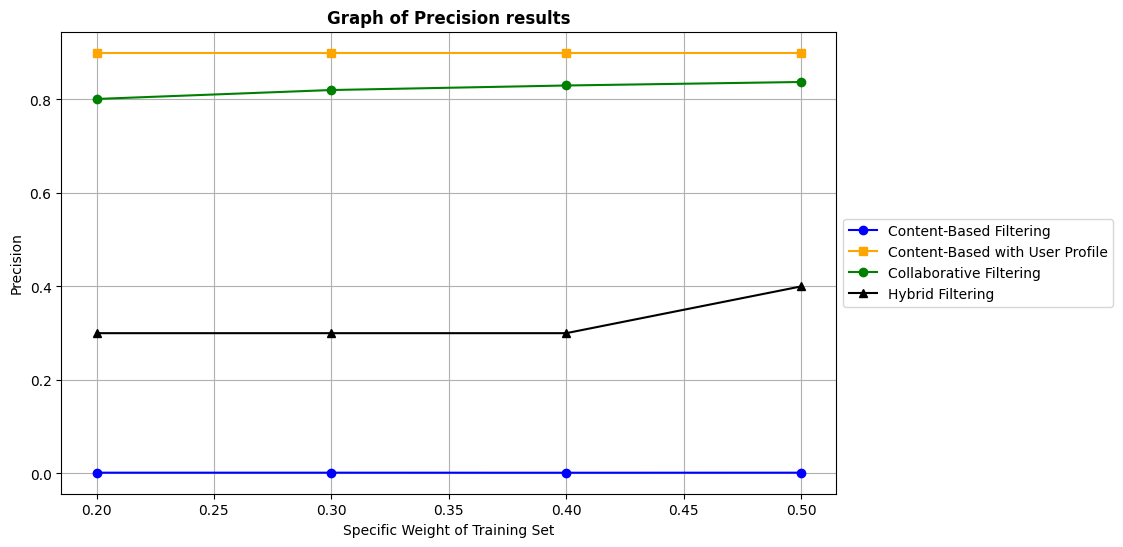

In [10]:
# Define the test sizes and corresponding training set proportions
test_sizes = [0.2, 0.3, 0.4, 0.5]

# Define the precision results for all four algorithms
precision_results = {
    'Specific Weight of Training Set': test_sizes,
    'Content-Based filtering Algorithm': [0.0016, 0.0016, 0.0015, 0.0016],
    'Content-Based filtering with user profile Algorithm': [0.8999, 0.8999, 0.8999, 0.8999],
    'Collaborative filtering Algorithm': [0.8010, 0.8201, 0.8298, 0.8373],
    'Hybrid filtering Algorithm': [0.3, 0.3, 0.3, 0.4]

}

# Create DataFrame
df = pd.DataFrame(precision_results)

display_data_in_table(df, "Precision Results for Different Recommendation Algorithms")
display_data_in_graph(df, 'Graph of Precision results', 'Precision')

**Precision at N (Precision@N)** is a metric used in recommendation systems to measure how many of the top-N recommended items are relevant to the user. It is calculated as the ratio of relevant items retrieved in the top-N recommendations to the total number of recommendations (N). Higher precision values indicate better performance.

##### Analysis of Precision@N Results

1. **Content-Based Filtering Algorithm:**
   - Precision@N: Consistently around 0.0016 across all test sizes.
   - **Performance:** Very low precision, suggesting that this algorithm is not very effective in retrieving relevant items in the top-N recommendations.

2. **Content-Based Filtering with User Profile Algorithm:**
   - Precision@N: Constant at 0.8999 across all test sizes.
   - **Performance:** Exceptionally high precision, indicating that this algorithm is highly effective in recommending relevant items.

3. **Collaborative Filtering Algorithm:**
   - Precision@N: Ranges from 0.8010 to 0.8373, with slight improvement as the test size increases.
   - **Performance:** Very good precision, showing strong performance, though slightly lower than the user profile-based content filtering.

4. **Hybrid Filtering Algorithm:**
   - Precision@N: Starts at 0.3 and increases to 0.4 as the test size increases.
   - **Performance:** Moderate precision, with better performance as the test size increases, but it is still significantly lower than the other algorithms except for the standard content-based filtering.

##### Ranking Based on Precision@N
1. **Content-Based Filtering with User Profile Algorithm:** 0.8999
2. **Collaborative Filtering Algorithm:** Ranges from 0.8010 to 0.8373
3. **Hybrid Filtering Algorithm:** Ranges from 0.3 to 0.4
4. **Content-Based Filtering Algorithm:** Ranges from 0.0015 to 0.0016

**Best Algorithm:** The **Content-Based Filtering with User Profile Algorithm** consistently performs the best based on Precision@N, followed by the Collaborative Filtering Algorithm.

##### Recall

Specific Weight of Training Set,Content-Based filtering Algorithm,Content-Based filtering with user profile Algorithm,Collaborative filtering Algorithm,Hybrid filtering Algorithm
0.2,0.0151,0.15,0.5087,0.0625
0.3,0.0154,0.15,0.3609,0.0714
0.4,0.0133,0.15,0.2783,0.0857
0.5,0.0153,0.15,0.2260,0.1290


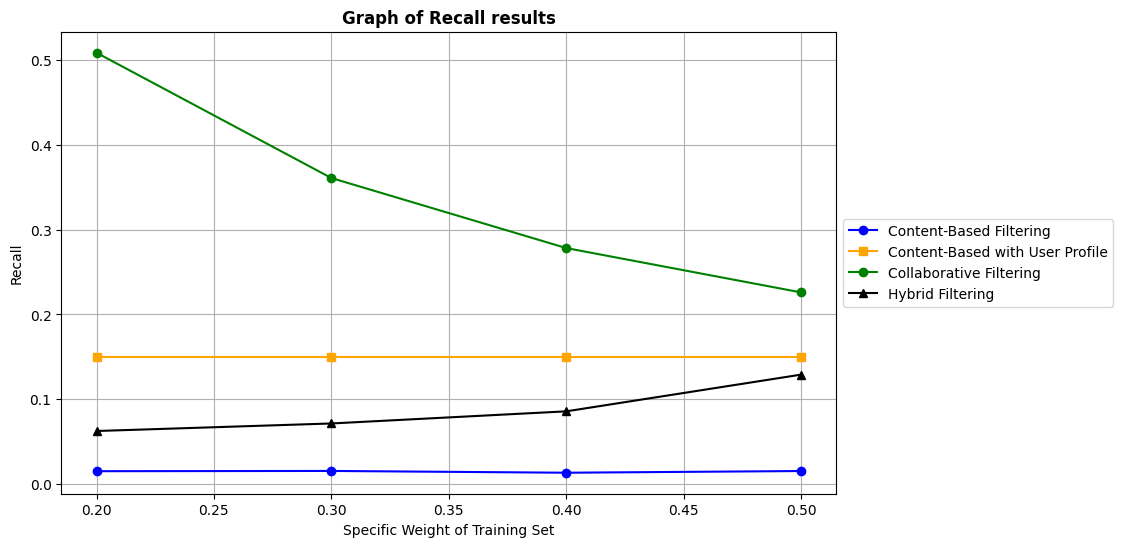

In [11]:
# Define the test sizes and corresponding training set proportions
test_sizes = [0.2, 0.3, 0.4, 0.5]

# Define the recall results for all four algorithms
recall_results = {
    'Specific Weight of Training Set': test_sizes,
    'Content-Based filtering Algorithm': [0.0151, 0.0154, 0.0133, 0.0153],
    'Content-Based filtering with user profile Algorithm': [0.1500, 0.1500, 0.1500, 0.1500],
    'Collaborative filtering Algorithm': [0.5087, 0.3609, 0.2783, 0.2260],
    'Hybrid filtering Algorithm': [0.0625, 0.0714, 0.0857, 0.1290]

}

# Create DataFrame
df = pd.DataFrame(recall_results)

display_data_in_table(df, "Recall Results for Different Recommendation Algorithms")
display_data_in_graph(df, 'Graph of Recall results', 'Recall')

**Recall at N (Recall@N)** is a metric that measures the proportion of relevant items that have been retrieved in the top-N recommendations out of all relevant items available. It focuses on how well the recommendation system is at covering all the relevant items for a user.

##### Analysis of Recall@N Results
1. **Content-Based Filtering Algorithm:**
   - Recall@N: Ranges from 0.0133 to 0.0154.
   - **Performance:** Very low recall, indicating that the algorithm is retrieving only a small fraction of the relevant items.

2. **Content-Based Filtering with User Profile Algorithm:**
   - Recall@N: Constant at 0.1500 across all test sizes.
   - **Performance:** Moderate recall, suggesting a consistent but limited ability to retrieve relevant items.

3. **Collaborative Filtering Algorithm:**
   - Recall@N: Ranges from 0.5087 down to 0.2260, decreasing as the test size increases.
   - **Performance:** Strong initial recall, especially at smaller test sizes, but it decreases with larger test sizes. Despite the decrease, it still performs better than the other algorithms in terms of retrieving a higher proportion of relevant items.

4. **Hybrid Filtering Algorithm:**
   - Recall@N: Ranges from 0.0625 to 0.1290, with an increase as the test size increases.
   - **Performance:** Moderate recall, improving with larger test sizes but still lower than collaborative filtering.

##### Ranking Based on Recall@N
1. **Collaborative Filtering Algorithm:** Highest recall at smaller test sizes, though it decreases with larger test sizes.
2. **Content-Based Filtering with User Profile Algorithm:** Consistent recall at 0.1500, placing it second.
3. **Hybrid Filtering Algorithm:** Starts lower but improves with larger test sizes.
4. **Content-Based Filtering Algorithm:** Lowest recall, indicating poor performance in retrieving relevant items.

**Best Algorithm:** The **Collaborative Filtering Algorithm** generally performs the best based on Recall@N, particularly at smaller test sizes, making it the most effective in retrieving relevant items overall.

##### NDCG

Specific Weight of Training Set,Content-Based filtering Algorithm,Content-Based filtering with user profile Algorithm,Collaborative filtering Algorithm,Hybrid filtering Algorithm
0.2,0.0108,0.9148,0.7832,0.2547
0.3,0.0090,0.9148,0.7516,0.2743
0.4,0.0090,0.9148,0.7384,0.4252
0.5,0.0094,0.9148,0.7331,0.3610


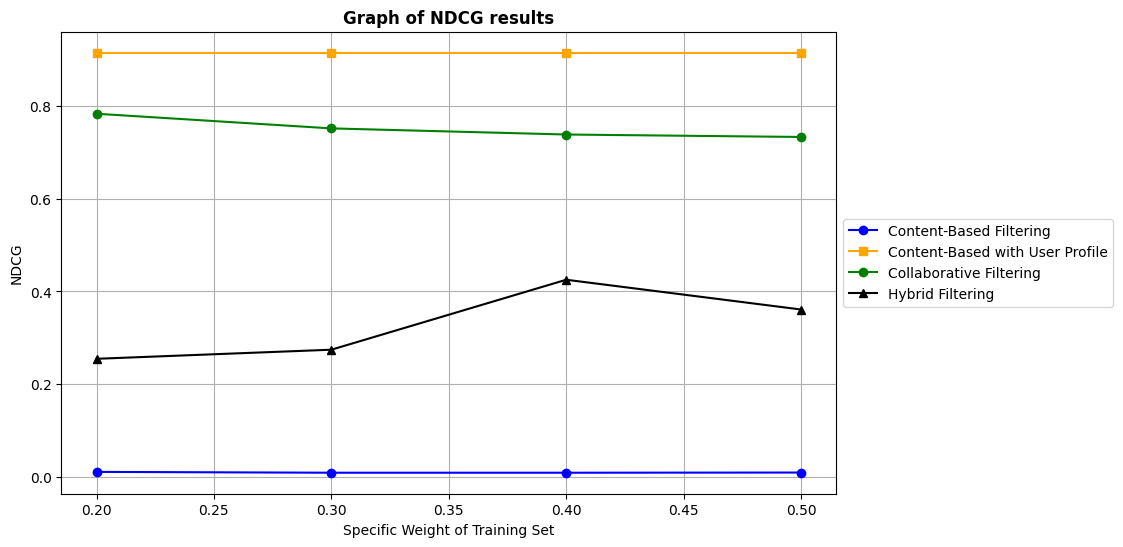

In [12]:
# Define the test sizes and corresponding training set proportions
test_sizes = [0.2, 0.3, 0.4, 0.5]

# Define the ndcg results for all four algorithms
ndcg_results = {
    'Specific Weight of Training Set': test_sizes,
    'Content-Based filtering Algorithm': [0.0108, 0.0090, 0.0090, 0.0094],
    'Content-Based filtering with user profile Algorithm': [0.9148, 0.9148, 0.9148, 0.9148],
    'Collaborative filtering Algorithm': [0.7832, 0.7516, 0.7384, 0.7331],
    'Hybrid filtering Algorithm': [0.2547, 0.2743, 0.4252, 0.3610]

}

# Create DataFrame
df = pd.DataFrame(ndcg_results)

display_data_in_table(df, "NDCG Results for Different Recommendation Algorithms")
display_data_in_graph(df, 'Graph of NDCG results', 'NDCG')

**NDCG (Normalized Discounted Cumulative Gain)** is a metric used to evaluate the quality of ranking in recommendation systems. It takes into account both the relevance of the recommended items and their positions in the list. The DCG (Discounted Cumulative Gain) measures the gain (relevance) accumulated from the top of the list to the bottom, with lower-ranked items discounted logarithmically. NDCG normalizes this value by the ideal DCG (IDCG), providing a score between 0 and 1, where 1 indicates a perfect ranking.

##### Analysis of NDCG Results

1. **Content-Based Filtering Algorithm:**
   - NDCG: Ranges from 0.0090 to 0.0108.
   - **Performance:** Very low NDCG, suggesting poor ranking quality and relevance of the recommended items.

2. **Content-Based Filtering with User Profile Algorithm:**
   - NDCG: Constant at 0.9148 across all test sizes.
   - **Performance:** Exceptionally high NDCG, indicating that the recommended items are both highly relevant and well-ranked. This algorithm consistently produces near-optimal rankings.

3. **Collaborative Filtering Algorithm:**
   - NDCG: Ranges from 0.7331 to 0.7832, with a slight decline as the test size increases.
   - **Performance:** Strong NDCG, indicating good ranking quality, though slightly lower than the user profile-based content filtering.

4. **Hybrid Filtering Algorithm:**
   - NDCG: Ranges from 0.2547 to 0.4252, with an improvement as the test size increases, followed by a slight decline.
   - **Performance:** Moderate NDCG, better than standard content-based filtering but significantly lower than the other two algorithms.

##### Ranking Based on NDCG
1. **Content-Based Filtering with User Profile Algorithm:** 0.9148
2. **Collaborative Filtering Algorithm:** Ranges from 0.7331 to 0.7832
3. **Hybrid Filtering Algorithm:** Ranges from 0.2547 to 0.4252
4. **Content-Based Filtering Algorithm:** Ranges from 0.0090 to 0.0108

**Best Algorithm:** The **Content-Based Filtering with User Profile Algorithm** clearly performs the best based on NDCG, offering the most relevant and well-ranked recommendations. The Collaborative Filtering Algorithm also performs well, while the Hybrid and standard Content-Based Filtering Algorithms lag behind.

##### MRR

Specific Weight of Training Set,Content-Based filtering Algorithm,Content-Based filtering with user profile Algorithm,Collaborative filtering Algorithm,Hybrid filtering Algorithm
0.2,0.0095,1.0,0.9204,0.3333
0.3,0.0071,1.0,0.9248,0.3333
0.4,0.0070,1.0,0.9270,1.0000
0.5,0.0076,1.0,0.9290,0.5000


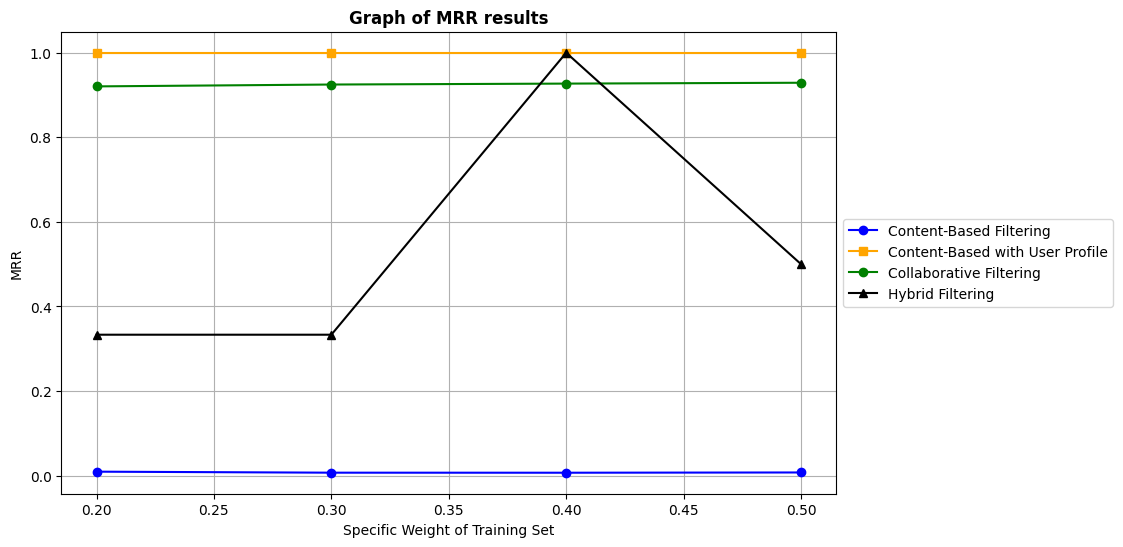

In [13]:
# Define the test sizes and corresponding training set proportions
test_sizes = [0.2, 0.3, 0.4, 0.5]

# Define the mrr results for all four algorithms
mrr_results = {
    'Specific Weight of Training Set': test_sizes,
    'Content-Based filtering Algorithm': [0.0095, 0.0071, 0.0070, 0.0076],
    'Content-Based filtering with user profile Algorithm': [1.0, 1.0, 1.0, 1.0],
    'Collaborative filtering Algorithm': [0.9204, 0.9248, 0.9270, 0.9290],
    'Hybrid filtering Algorithm': [0.3333, 0.3333, 1.0, 0.5]

}

# Create DataFrame
df = pd.DataFrame(mrr_results)

display_data_in_table(df, "MRR Results for Different Recommendation Algorithms")
display_data_in_graph(df, 'Graph of MRR results', 'MRR')

**MRR (Mean Reciprocal Rank)** is a metric used in information retrieval and recommendation systems to evaluate the effectiveness of ranking. It measures the average of the reciprocal ranks of the first relevant item in each query. A higher MRR value indicates that relevant items are ranked higher on average, with a score of 1 indicating that the relevant item is always the first result.

##### Analysis of MRR Results

1. **Content-Based Filtering Algorithm:**
   - MRR: Ranges from 0.0070 to 0.0095.
   - **Performance:** Very low MRR, indicating that relevant items are rarely ranked highly in the recommendations, often appearing lower in the list.

2. **Content-Based Filtering with User Profile Algorithm:**
   - MRR: Constant at 1.0 across all test sizes.
   - **Performance:** Perfect MRR, indicating that this algorithm consistently ranks the relevant item first in the list of recommendations. This is the best possible performance in terms of ranking relevant items.

3. **Collaborative Filtering Algorithm:**
   - MRR: Ranges from 0.9204 to 0.9290, with a slight increase as the test size increases.
   - **Performance:** Excellent MRR, indicating that relevant items are ranked very highly on average, though not as perfectly as the user profile-based content filtering.

4. **Hybrid Filtering Algorithm:**
   - MRR: Ranges from 0.3333 to 1.0, with significant variability depending on the test size.
   - **Performance:** Mixed performance, with some test sizes showing perfect MRR and others significantly lower. This variability suggests that the effectiveness of the hybrid approach may depend heavily on specific conditions.

##### Ranking Based on MRR
1. **Content-Based Filtering with User Profile Algorithm:** 1.0
2. **Collaborative Filtering Algorithm:** Ranges from 0.9204 to 0.9290
3. **Hybrid Filtering Algorithm:** Ranges from 0.3333 to 1.0 (depending on test size)
4. **Content-Based Filtering Algorithm:** Ranges from 0.0070 to 0.0095

**Best Algorithm:** The **Content-Based Filtering with User Profile Algorithm** performs the best based on MRR, consistently ranking relevant items first. The Collaborative Filtering Algorithm also shows strong performance, while the Hybrid Filtering Algorithm has more variable results. The standard Content-Based Filtering Algorithm has the weakest performance in ranking relevant items highly.

##### F1

Specific Weight of Training Set,Content-Based filtering Algorithm,Content-Based filtering with user profile Algorithm,Collaborative filtering Algorithm,Hybrid filtering Algorithm
0.2,0.0031,0.9473,0.8232,0.4615
0.3,0.0031,0.9473,0.8227,0.4615
0.4,0.0027,0.9473,0.8225,0.4615
0.5,0.0031,0.9473,0.8222,0.5714


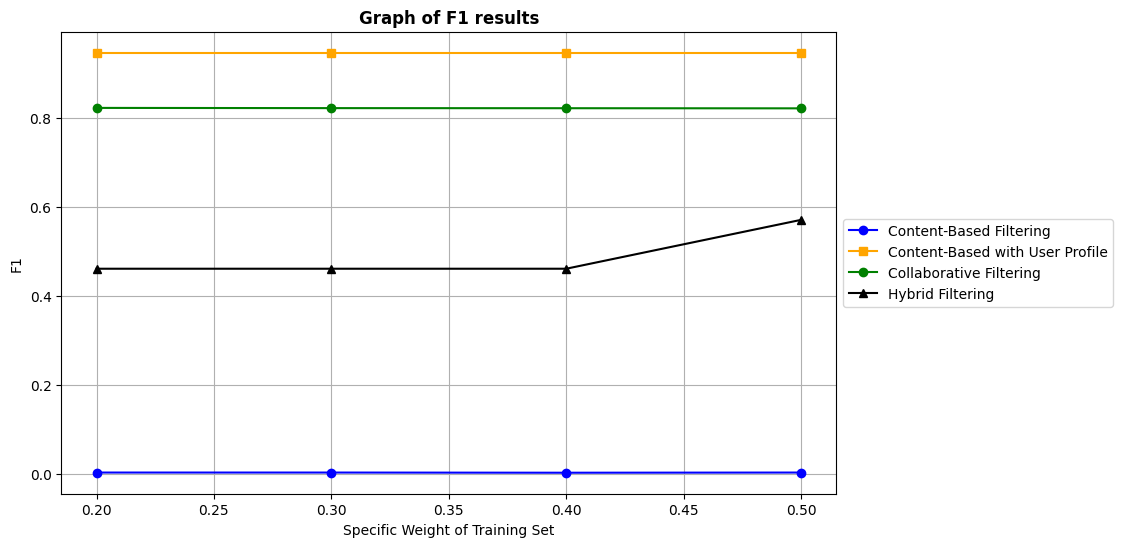

In [14]:
# Define the test sizes and corresponding training set proportions
test_sizes = [0.2, 0.3, 0.4, 0.5]

# Define the f1 results for all four algorithms
f1_results = {
    'Specific Weight of Training Set': test_sizes,
    'Content-Based filtering Algorithm': [0.0031, 0.0031, 0.0027, 0.0031],
    'Content-Based filtering with user profile Algorithm': [0.9473, 0.9473, 0.9473, 0.9473],
    'Collaborative filtering Algorithm': [0.8232, 0.8227, 0.8225, 0.8222],
    'Hybrid filtering Algorithm': [0.4615, 0.4615, 0.4615, 0.5714]

}

# Create DataFrame
df = pd.DataFrame(f1_results)

display_data_in_table(df, "F1 Results for Different Recommendation Algorithms")
display_data_in_graph(df, 'Graph of F1 results', 'F1')

**F1 Score** is a metric that combines precision and recall into a single score. It is the harmonic mean of precision and recall, providing a balanced measure that considers both false positives and false negatives. The F1 score ranges from 0 to 1, with 1 indicating perfect precision and recall.

##### Analysis of F1 Results

1. **Content-Based Filtering Algorithm:**
   - F1 Score: Ranges from 0.0027 to 0.0031.
   - **Performance:** Very low F1 score, indicating poor balance between precision and recall. This algorithm struggles with both identifying and correctly ranking relevant items.

2. **Content-Based Filtering with User Profile Algorithm:**
   - F1 Score: Constant at 0.9473 across all test sizes.
   - **Performance:** Exceptionally high F1 score, suggesting that this algorithm excels in both precision and recall, achieving a near-perfect balance.

3. **Collaborative Filtering Algorithm:**
   - F1 Score: Ranges from 0.8222 to 0.8232, with very slight variation.
   - **Performance:** Strong F1 score, indicating good balance between precision and recall, though not as high as the user profile-based content filtering.

4. **Hybrid Filtering Algorithm:**
   - F1 Score: Ranges from 0.4615 to 0.5714, with an improvement as the test size increases.
   - **Performance:** Moderate F1 score, with noticeable improvement at larger test sizes, though it remains lower than the other two leading algorithms.

##### Ranking Based on F1 Score
1. **Content-Based Filtering with User Profile Algorithm:** 0.9473
2. **Collaborative Filtering Algorithm:** Ranges from 0.8222 to 0.8232
3. **Hybrid Filtering Algorithm:** Ranges from 0.4615 to 0.5714
4. **Content-Based Filtering Algorithm:** Ranges from 0.0027 to 0.0031

**Best Algorithm:** The **Content-Based Filtering with User Profile Algorithm** performs the best based on the F1 score, indicating an excellent balance between precision and recall. The Collaborative Filtering Algorithm also shows strong performance, while the Hybrid Filtering Algorithm is more moderate. The standard Content-Based Filtering Algorithm has the weakest performance in balancing precision and recall.

##### Accuracy

Specific Weight of Training Set,Content-Based filtering Algorithm,Content-Based filtering with user profile Algorithm,Collaborative filtering Algorithm,Hybrid filtering Algorithm
0.2,0.0015,0.8999,0.7389,0.3
0.3,0.0015,0.8999,0.7377,0.3
0.4,0.0013,0.8999,0.7371,0.3
0.5,0.0016,0.8999,0.7363,0.4


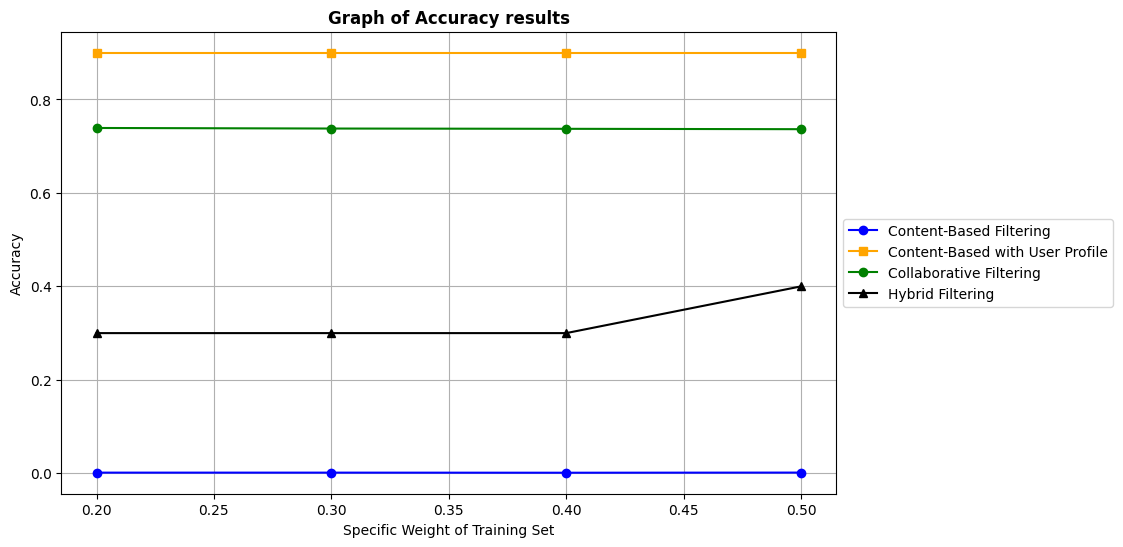

In [15]:
# Define the test sizes and corresponding training set proportions
test_sizes = [0.2, 0.3, 0.4, 0.5]

# Define the accuracy results for all four algorithms
accuracy_results = {
    'Specific Weight of Training Set': test_sizes,
    'Content-Based filtering Algorithm': [0.0015, 0.0015, 0.0013, 0.0016],
    'Content-Based filtering with user profile Algorithm': [0.8999, 0.8999, 0.8999, 0.8999],
    'Collaborative filtering Algorithm': [0.7389, 0.7377, 0.7371, 0.7363],
    'Hybrid filtering Algorithm': [0.3, 0.3, 0.3, 0.4]

}

# Create DataFrame
df = pd.DataFrame(accuracy_results)

display_data_in_table(df, 'Accuracy Results for Different Recommendation Algorithms')
display_data_in_graph(df, 'Graph of Accuracy results', 'Accuracy')

**Accuracy** is a metric that measures the proportion of correct predictions (both true positives and true negatives) made by a model out of the total number of predictions. 
Accuracy is useful for evaluating a model when the classes are balanced, but it may be misleading in cases where the classes are imbalanced.

##### Analysis of Accuracy Results

1. **Content-Based Filtering Algorithm:**
   - Accuracy: Ranges from 0.0013 to 0.0016.
   - **Performance:** Extremely low accuracy, indicating that this algorithm rarely makes correct predictions, resulting in poor overall performance.

2. **Content-Based Filtering with User Profile Algorithm:**
   - Accuracy: Constant at 0.8999 across all test sizes.
   - **Performance:** High accuracy, suggesting that this algorithm makes correct predictions most of the time, offering reliable performance across different test sizes.

3. **Collaborative Filtering Algorithm:**
   - Accuracy: Ranges from 0.7363 to 0.7389, with very slight variation as the test size changes.
   - **Performance:** Good accuracy, though not as high as the user profile-based content filtering, indicating that it generally makes correct predictions but is slightly less reliable.

4. **Hybrid Filtering Algorithm:**
   - Accuracy: Ranges from 0.3 to 0.4, with a slight improvement as the test size increases.
   - **Performance:** Moderate accuracy, better than standard content-based filtering but significantly lower than the other two leading algorithms.

##### Ranking Based on Accuracy
1. **Content-Based Filtering with User Profile Algorithm:** 0.8999
2. **Collaborative Filtering Algorithm:** Ranges from 0.7363 to 0.7389
3. **Hybrid Filtering Algorithm:** Ranges from 0.3 to 0.4
4. **Content-Based Filtering Algorithm:** Ranges from 0.0013 to 0.0016

**Best Algorithm:** The **Content-Based Filtering with User Profile Algorithm** performs the best based on accuracy, indicating a high rate of correct predictions. The Collaborative Filtering Algorithm also shows good performance, while the Hybrid Filtering Algorithm has moderate accuracy. The standard Content-Based Filtering Algorithm has the weakest performance in terms of accuracy.

### Overall Assessment

##### 1. **Content-Based Filtering Algorithm**
   - **Precision@N:** 0.0015 - 0.0016 (Very low)
   - **Recall@N:** 0.0133 - 0.0154 (Very low)
   - **NDCG:** 0.0090 - 0.0108 (Very low)
   - **MRR:** 0.0070 - 0.0095 (Very low)
   - **F1 Score:** 0.0027 - 0.0031 (Very low)
   - **Accuracy:** 0.0013 - 0.0016 (Very low)
   - **Overall Performance:** Consistently poor across all metrics.

##### 2. **Content-Based Filtering with User Profile Algorithm**
   - **Precision@N:** 0.8999 (Very high)
   - **Recall@N:** 0.1500 (Moderate)
   - **NDCG:** 0.9148 (Very high)
   - **MRR:** 1.0 (Perfect)
   - **F1 Score:** 0.9473 (Very high)
   - **Accuracy:** 0.8999 (Very high)
   - **Overall Performance:** Best overall, with top performance in most metrics, particularly in ranking metrics (MRR, NDCG).

##### 3. **Collaborative Filtering Algorithm**
   - **Precision@N:** 0.8010 - 0.8373 (High)
   - **Recall@N:** 0.2260 - 0.5087 (High to moderate, decreases with test size)
   - **NDCG:** 0.7331 - 0.7832 (High)
   - **MRR:** 0.9204 - 0.9290 (Very high)
   - **F1 Score:** 0.8222 - 0.8232 (High)
   - **Accuracy:** 0.7363 - 0.7389 (High)
   - **Overall Performance:** Consistently strong performance across all metrics, but slightly below the Content-Based with User Profile Algorithm.

##### 4. **Hybrid Filtering Algorithm**
   - **Precision@N:** 0.3 - 0.4 (Moderate)
   - **Recall@N:** 0.0625 - 0.1290 (Moderate)
   - **NDCG:** 0.2547 - 0.4252 (Moderate)
   - **MRR:** 0.3333 - 1.0 (Variable, sometimes perfect)
   - **F1 Score:** 0.4615 - 0.5714 (Moderate)
   - **Accuracy:** 0.3 - 0.4 (Moderate)
   - **Overall Performance:** Moderate performance, with some variability and occasional strong results (e.g., MRR).

##### Final Ranking
1. **Content-Based Filtering with User Profile Algorithm:** Best overall, excelling in most metrics, particularly in ranking-related metrics.
2. **Collaborative Filtering Algorithm:** Strong across all metrics, but slightly less effective than the user profile-based content filtering.
3. **Hybrid Filtering Algorithm:** Moderate performance with some variability, occasionally matching top performance in specific metrics like MRR.
4. **Content-Based Filtering Algorithm:** Weakest performance, consistently low across all metrics.

**Best Algorithm:** The **Content-Based Filtering with User Profile Algorithm** is the best performer overall across different metrics.